# Exploring Sweden’s Job Market Geography: A Look at Arbetsförmedlingen Data

---

## 1. Introduction

**Where are the jobs in Sweden, really?** Working with publicly available data from Arbetsförmedlingen (Sweden’s Public Employment Service), we can map out where employers are hiring, how many vacancies they are offering, and in which fields. By combining these job listings with **population statistics** and **municipality boundaries**, we can explore:

- Which municipalities (kommuner) have the most job listings in raw terms?
- Are there smaller municipalities where job density (jobs per capita) is unexpectedly high?
- Which **occupation fields** (e.g., Data/IT, Hälso- och sjukvård, Administration, etc.) are prominent in specific areas?
- Finally we'll look at the specifically the distribution of Data/IT over Sweden's regions.

This post has two goals: to show how to collect and prepare data and to display where jobs are located in Swedish municipalities. It provides useful information for job seekers, policymakers, and anyone interested in Sweden’s job market.

---

## 2. Data


This project relies on **three main data sources**:

1. **Arbetsförmedlingen Job Listings**  
   - Retrieved from the open API: `https://jobstream.api.jobtechdev.se/snapshot`.  
   - Contains ~39,000 job listings, with key fields:job location, occupational category (e.g., “Data/IT”), open positions per listing.

2. **Municipality Population**  
    - Scraped from a [Wikipedia table of Swedish municipalities](https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_Sveriges_kommuner), including population and region (län).  



3. **Geographic Boundaries (GeoJSON)**  
   - Files `swedish_municipalities.geojson` and `swedish_regions.geojson` sourced from [Open Knowledge Foundation Sweden](https://github.com/okfse) for **choropleth** maps to visualize data.


---

## 3. Data Collection & Wrangling
We gather data from various sources, including job listings, population stats, and geographic boundaries, then clean and format it to ensure accurate, compatible visuals.

### 3.1 Job Listings
We collect job listing data from Arbetsförmedlingen's API, including location, categories, and vacancies, and store it locally for reproducibility. Missing `number_of_vacancies` values are set to `1`, assuming at least one position. The cleaned dataset is then prepared for integration. The cleaned dataset is saved as a JSON file, which couldn't be uploaded to GitHub due to being larger than 100 MB.

In [1]:
import requests
import json
import pandas as pd
import numpy as np


def fetch_and_process_job_listings():
    """
    Fetch job listings from an API, save to a file, and return as a DataFrame.
    """
    url = "https://jobstream.api.jobtechdev.se/snapshot"

    # Use API
    response = requests.get(url)

    # Get JSON
    job_listings = response.json()

    # Save to a file for reproducibility
    with open("job_listings.json", "w") as file:
        json.dump(job_listings, file)

    # JSON to a DataFrame
    job_listings_df = pd.DataFrame(job_listings)

    # Replace NaN values in 'number_of_vacancies' with 1
    job_listings_df['number_of_vacancies'] = job_listings_df['number_of_vacancies'].fillna(1)

    return job_listings_df

# Getting the job listing DataFrame
job_listings_df = fetch_and_process_job_listings()

### 3.2 Population Data

We scrape a Wikipedia page to collect data on Swedish municipalities, their region names (län), and populations. This information is essential for analyzing job density and creating meaningful visualizations. 

To align the scraped data with the job listing dataset, we clean it by:  
1. Removing the "kommun" suffix from municipality names (e.g., "Stockholms kommun" becomes "Stockholm").  
2. Adjusting names ending in 's' after a non-vowel (e.g., "Danderyds" becomes "Danderyd") while keeping exceptions like "Degerfors" unchanged.  
3. Applying manual fixes for cases like "Falun" and "Grums" due to cleaning quirks.

The cleaned data is saved to a CSV file, `swedish_municipalities_population.csv`, for reproducibility.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

def scrape_swedish_municipalities():
    """
    NOTE: BOTH Saves data to a CSV and returns it as a DataFrame.    
    
    Scrapes Swedish municipalities, the regions they belong to, and their populations
    from a Wikipedia page.

    - Fetches and parses HTML content of the Wikipedia page.
    - Extracts municipality names, region (län) names, and population data from the relevant table.
    - Cleans the data and saves it to 'swedish_municipalities_population.csv'.

    Returns:
        pandas.DataFrame: A DataFrame with columns 'Municipality', 'Region', and 'Population'.
    """
    
    # URL of the Wikipedia page
    url = "https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_Sveriges_kommuner"
    
    # Send a GET request to the webpage
    response = requests.get(url)
    
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table containing the municipalities and population data
    table = soup.find('table', {'class': 'wikitable'})
    
    # Extract table rows
    rows = table.find_all('tr')
    
    # Prepare lists to store the extracted data
    municipalities = []
    regions = []
    populations = []
    
    # Iterate through rows to extract data (skipping the header row)
    for row in rows[1:]:
        cols = row.find_all('td')

        #   cols[1] -> Municipality
        #   cols[3] -> Region
        #   cols[4] -> Population
        if len(cols) > 4:
            # Municipality name
            municipality = cols[1].get_text(strip=True)
            
            # Remove " kommun" suffix if present
            if municipality.endswith(" kommun"):
                municipality = municipality.replace(" kommun", "") 

            # Check if the municipality ends with a non-vowel, whitespace, and 's'
            if re.match(r".*[^aeiouyåäö]s$", municipality) and not municipality.endswith("ors"):
                municipality = re.sub(r"s$", "", municipality)
          
            # Region (län)
            region = cols[3].get_text(strip=True)
            
            # Remove " kommun" suffix if present
            if region.endswith(" län"):
                region = region.replace(" län", "")   

            # Remove hidden <span style="display:none"> from the population cell
            for hidden_span in cols[4].find_all('span', style='display:none'):
                hidden_span.decompose()
            
            # Now get only the visible text in that cell
            population_raw = cols[4].get_text(strip=True)

            # Remove non-breaking spaces and regular spaces
            population_raw = population_raw.replace('\xa0', '').replace(' ', '')

            # Append data
            municipalities.append(municipality)
            regions.append(region)
            populations.append(population_raw)
    
    # Update specific entries for exceptions
    municipalities = ["Falun" if name == "Falu" else "Grums" \
                      if name == "Grum" else name for name in municipalities]

    # Create a DataFrame to store the results
    data = pd.DataFrame({
        'Municipality': municipalities,
        'Region': regions,
        'Population': populations
    })
    
    # Convert population from string to int
    data["Population"] = data["Population"].astype(int)
    
    # Save to CSV
    data.to_csv('swedish_municipalities_population.csv', index=False, encoding='utf-8')
    
    return data

population_df = scrape_swedish_municipalities()

### 3.3 Aggregating Vacancies and Merging with Population Data

We calculate total vacancies for each municipality by summing the `number_of_vacancies` from all job listings. This data is then merged with the population dataset to compute job density, measured as jobs per 1,000 people (`Jobs_per_1000`) for later use. This metric highlights areas with notably high or low job availability relative to their population.

In [3]:
# Number of vacancies is added together by the municpality
df_jobs_by_muni = (
    job_listings_df
    .groupby(job_listings_df["workplace_address"]
    .apply(lambda x: x.get("municipality") if pd.notnull(x) else None)) 
    .agg({"number_of_vacancies": "sum"})
    .reset_index()
    .rename(columns={"workplace_address": "Municipality"})
)

# Merge with population data
merged_df = pd.merge(df_jobs_by_muni, population_df, on="Municipality", how="left")

# Create a new column with job density
merged_df["Jobs_per_1000"] = 1000 * merged_df["number_of_vacancies"] / merged_df["Population"]

## 4. Visual Analysis  

We explore the data through various visualizations:  
- **Bar Diagrams** to compare job vacancies across municipalities relative to population.  
- **Choropleth Maps** to show overall job density (jobs per 1,000 residents) and specific fields like Health Services, IT, and other key sectors.  
- **Tree Maps** to display job distribution across different occupation fields.  
- **Regional IT Maps** to highlight the geographic spread of Data/IT vacancies.  


### 4.1 Bar Chart Comparing Job Vacancies and Population
We create a bar chart showing the top 15 municipalities by total job vacancies, comparing vacancies (blue bars) to population (orange bars). Stockholm serves as the baseline, with equal-length bars for jobs and population. For other municipalities, longer blue bars indicate a job surplus, while longer orange bars indicate a population surplus. This provides a clear comparison of job availability relative to population.

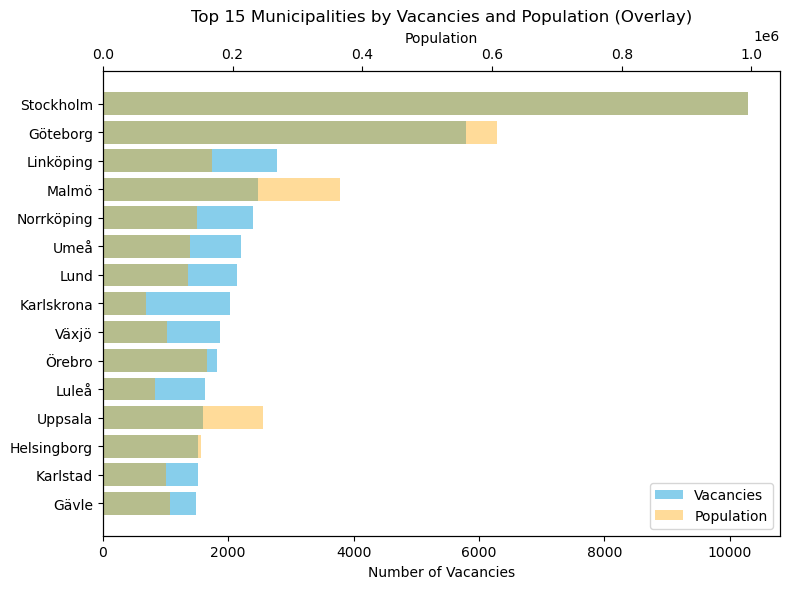

In [4]:
import matplotlib.pyplot as plt

# Identify top 15 municipalities by number_of_vacancies
top_15 = merged_df.nlargest(15, "number_of_vacancies")

fig, ax1 = plt.subplots(figsize=(8, 6))

# Create a twin x-axis sharing the same y-axis (municipalities)
ax2 = ax1.twiny()

# Plot vacancies on the first axis
vac_bars = ax1.barh(
    top_15["Municipality"], 
    top_15["number_of_vacancies"],
    color="skyblue", 
    label="Vacancies"
)

# Plot population on the second axis with some transparency
pop_bars = ax2.barh(
    top_15["Municipality"], 
    top_15["Population"], 
    color="orange", 
    alpha=0.4,        
    label="Population"
)

# Invert the y-axis so the largest bar is at the top
ax1.invert_yaxis()

# Label axes
ax1.set_xlabel("Number of Vacancies")
ax2.set_xlabel("Population")

# Title and layout
plt.title("Top 15 Municipalities by Vacancies and Population (Overlay)")

# A combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower right")

plt.tight_layout()
plt.show()

### Interpretation: Job Vacancies Across Municipalities

1. **Major Economic Hubs (Stockholm, Göteborg, Malmö)**:  
Stockholm, Göteborg, and Malmö have large populations but fewer jobs per capita, indicating higher competition or a mismatch between labor supply and demand.  

2. **Smaller and Mid-Sized Municipalities**:  
Towns like Växjö, Karlskrona, and Gävle have more jobs relative to their populations, likely due to specific industries, while Uppsala shows fewer vacancies, suggesting an oversaturated market.  

This challenges the assumption that larger cities offer the most opportunities, likely due to regional competition, economic factors, or incomplete job listings. Smaller and mid-sized municipalities often provide better job availability per capita.


### 4.2 Choropleth Map of Job Density Across Sweden

We create a choropleth map using `GeoPandas` to visualize job density across Sweden’s municipalities, measured as jobs per 1,000 residents. Darker colors represent areas with more jobs relative to their population. The map is generated by merging municipal boundaries with job density data and plotting a color gradient to show the distribution of job opportunities nationwide.

Skipping field geo_point_2d: unsupported OGR type: 3


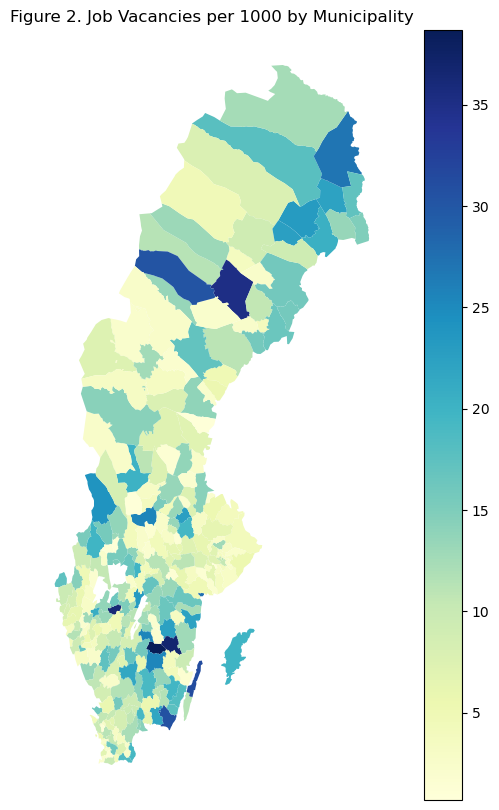

In [5]:
import geopandas as gpd

# Getting json to map
municipalities_geo = gpd.read_file("swedish_municipalities.geojson")

# Merge with the municipality-level data
geo_merged = pd.merge(municipalities_geo, merged_df, left_on="kom_namn", right_on="Municipality", how="left")

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_merged.plot(
    column="Jobs_per_1000",
    ax=ax,
    legend=True,
    cmap="YlGnBu",
    missing_kwds={"color": "black"}
)
plt.title("Figure 2. Job Vacancies per 1000 by Municipality")
plt.axis("off")
plt.show()

### Interpretation: Job Density Across Municipalities

1. **High Job Density in Smaller Municipalities**:  
some municipalities in northern Sweden, often have high job density due to specialized industries or large employers relative to their populations, leading to fluctuations in job availability per resident.  

2. **Lower Density Around Urban Centers**:  
Urban centers like Stockholm, Göteborg, and Malmö have lower job density in surrounding areas, as large populations dilute the metric despite significant economic activity.  

3. **Southern Sweden**:  
Southern Sweden generally shows higher and more stable job density, which we needs to be investigated more closely.

---


### 4.3 Treemap of Job Vacancies by Industry 

Using `squarify`, we create a **treemap** showing job vacancies across Sweden's occupation fields. Each section's size represents total vacancies, with unspecified fields labeled "Unknown." This visualization reveals dominant industries in the dataset, providing context for geographic patterns and aiding the analysis of job market trends.

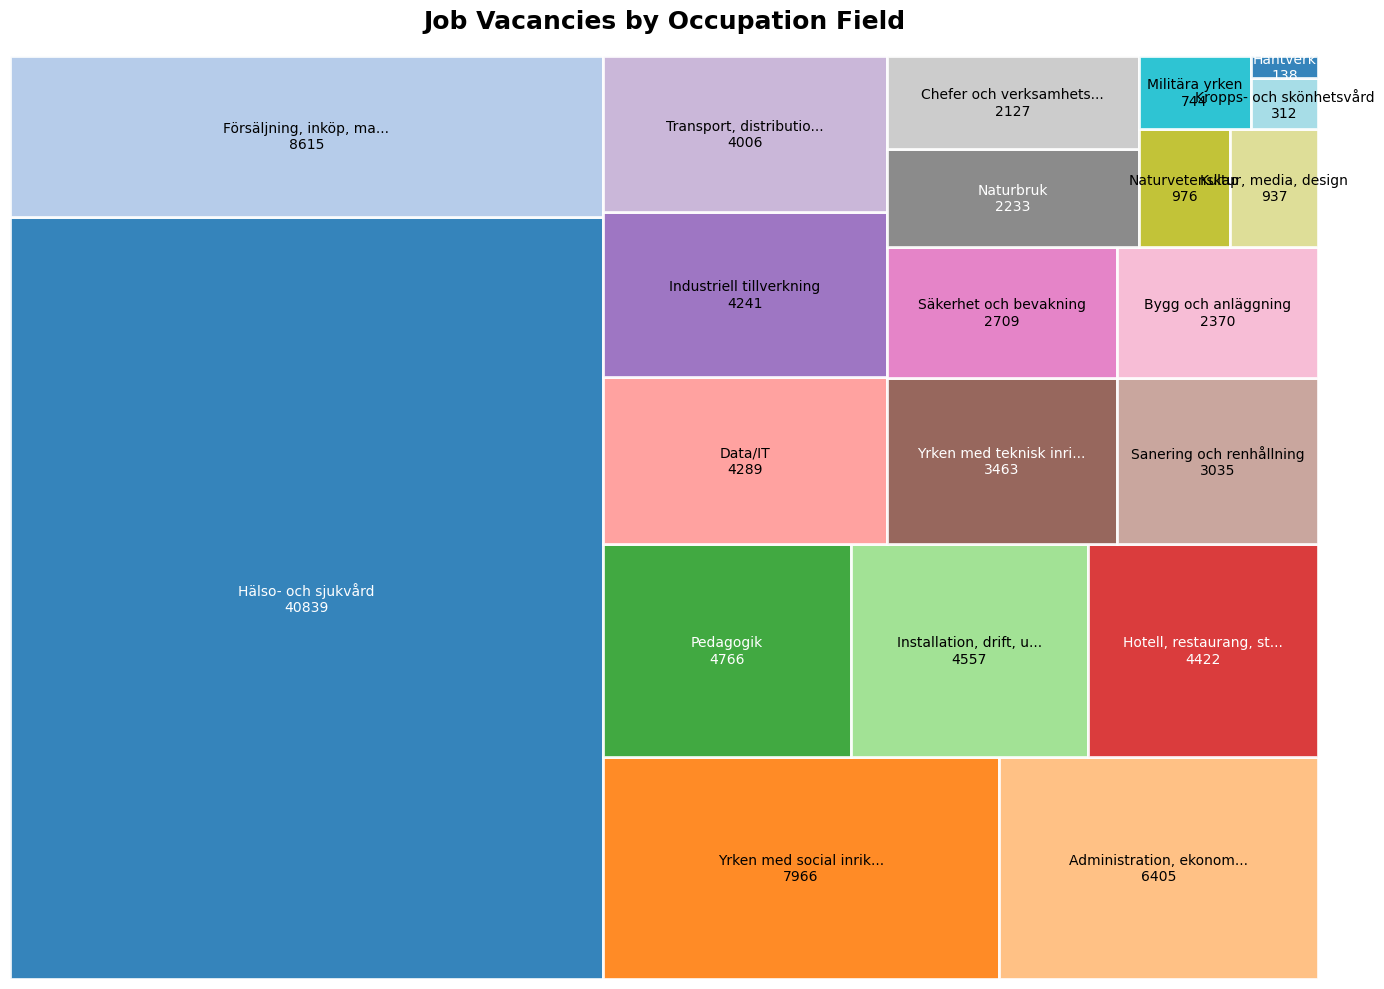

In [6]:
import squarify
import matplotlib.colors as mcolors # better colors

# Data preparation
# Handles cases where the field may not be present or is missing
df_occ_field = (
    job_listings_df
    .groupby(job_listings_df["occupation_field"].apply(lambda x: x.get("label") if pd.notnull(x) else "Unknown"))
    .agg({"number_of_vacancies": "sum"})
    .reset_index() 
    .sort_values("number_of_vacancies", ascending=False)
)

# Prepare data for treemap
labels = df_occ_field["occupation_field"] + "\n" + df_occ_field["number_of_vacancies"].astype(str)
sizes = df_occ_field["number_of_vacancies"]

# Create the treemap
plt.figure(figsize=(14, 10))

# Normalize the values for consistent coloring
sizes = df_occ_field["number_of_vacancies"]
colors = plt.cm.tab20.colors  # Use a categorical color palette

# Define labels and truncate long text
labels = df_occ_field["occupation_field"].apply(lambda x: x if len(x) < 25 else x[:22] + "...") + \
         "\n" + df_occ_field["number_of_vacancies"].astype(int).astype(str) # int removes ".0"

# Adjust font color dynamically based on box color
def get_label_color(bg_color):
    r, g, b = mcolors.to_rgb(bg_color)
    return "black" if (r + g + b) / 3 > 0.5 else "white"

# Assign colors to the treemap boxes
color_assignments = [colors[i % len(colors)] for i in range(len(sizes))]

# Plot the treemap
squarify.plot(
    sizes=sizes,
    label=labels,
    color=color_assignments,
    alpha=0.9,
    edgecolor="white",
    linewidth=2
)

# Dynamically update label colors
ax = plt.gca()  # Get current axis
for text, bg_color in zip(ax.texts, color_assignments):
    label_color = get_label_color(bg_color)
    text.set_color(label_color)

# Title and layout adjustments
plt.title("Job Vacancies by Occupation Field", fontsize=18, fontweight="bold", pad=20)
plt.axis("off")  # Remove axes
plt.tight_layout()  # Optimize spacing
plt.show()

### Interpretation: Treemap of Job Vacancies by Occupation Field  

The treemap reveals key patterns in Sweden’s job market:  

1. **Healthcare**: With 40,487 vacancies, healthcare is the largest sector. Its demand may stabilize job density across regions, but the opposite could be true—areas with aging populations and fewer younger workers might see higher concentrations of vacancies. Further analysis is needed to confirm these trends.

2. **Stable Sectors**: Fields like pedagogy likely have steady demand nationwide, contributing to a more uniform distribution of job density in some regions.  

3. **Urban Industries**: Sectors such as Sales, Administration, and Data/IT dominate in urban centers like Stockholm, Gothenburg, and Malmö, influencing job density and vacancy distribution in these areas.  

4. **Localized Industries**: Manufacturing, Agriculture, and Military Careers tend to concentrate in low-population areas, where large employers can create significant job density spikes.  

To deepen this analysis, we propose focusing on:  
- **Data/IT Jobs**: To explore regional demand.  
- **Service Jobs**: To examine urban-rural trends, particularly in hospitality and retail.  
- **Healthcare Jobs**: Assessing healthcare’s influence on job density across regions.

### 4.4 Job Density by Sector: Health, Service, and Data/IT  
We create three **choropleth maps** to illustrate job density (jobs per 1,000 residents) for **Health**, **Service**, and **Data/IT** sectors across Sweden. Occupation fields are grouped, and job density is normalized by municipality. Each map uses distinct colors, with high-density municipalities labeled for clarity. Service jobs, such as sales, hospitality, cleaning, and security, often reflect local needs or tourism-driven demand. These maps reveal how job opportunities differ across sectors and regions in Sweden.

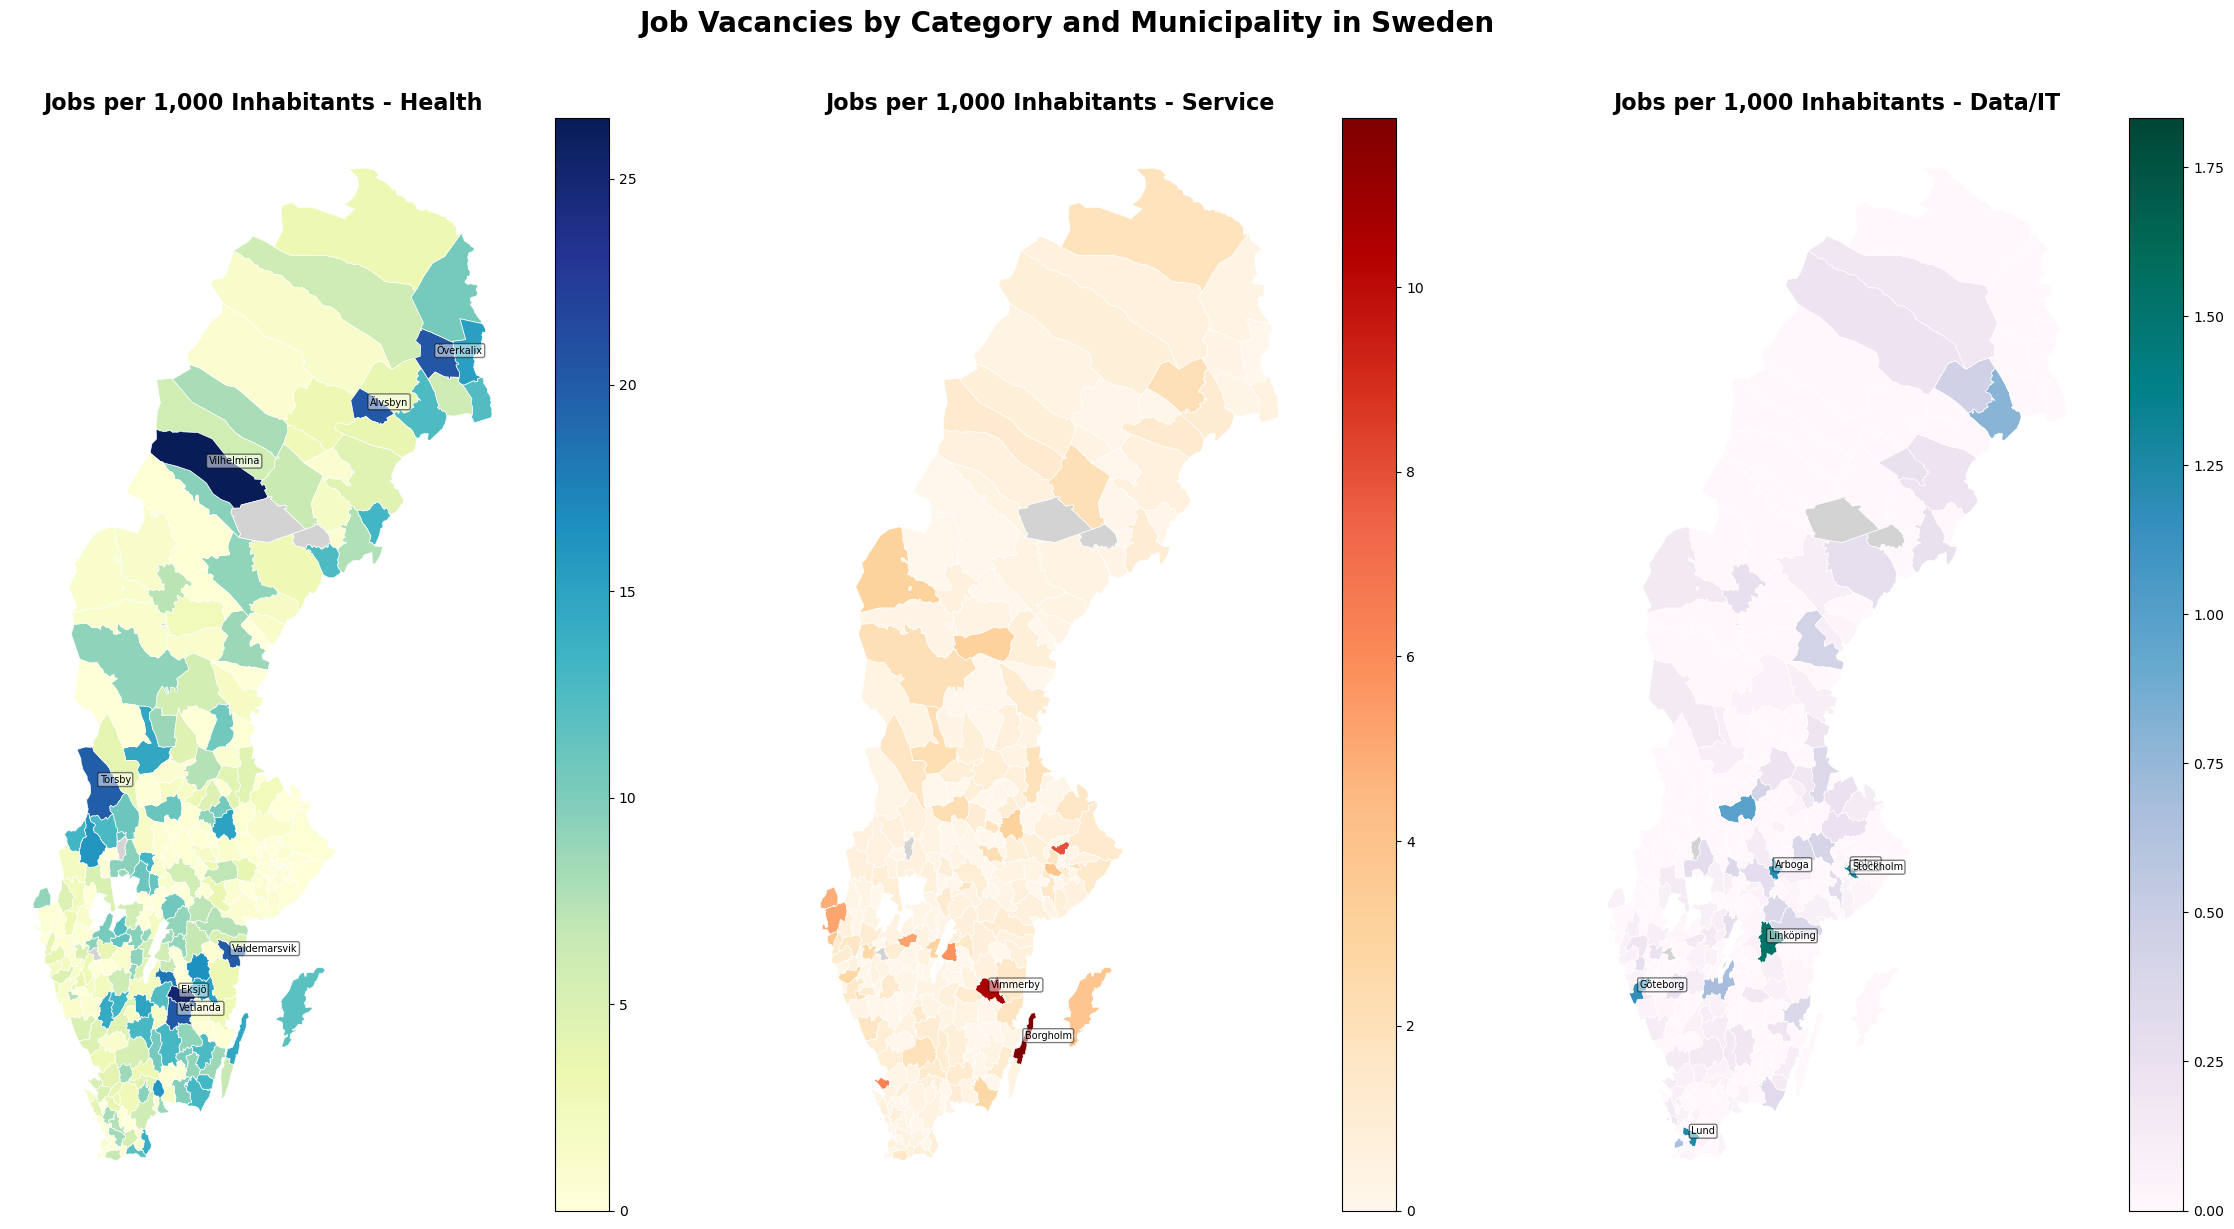

In [7]:
# Mapping occupation fields to broader categories for analysis
category_mapping = {
    "Hälso- och sjukvård": "Health",
    "Hotell, restaurang, storhushåll": "Service",
    "Sanering och renhållning": "Service",
    "Kropps- och skönhetsvård": "Service",
    "Säkerhet och bevakning": "Service",
    "Data/IT": "Data/IT",
}

# Extract Municipality from 'workplace_address'
job_listings_df['Municipality'] = job_listings_df['workplace_address'].apply(
    lambda x: x.get('municipality') if isinstance(x, dict) else 'Unknown'
)

# Extract occupation labels from 'occupation_field' and Adds a new column for the label of each job category
job_listings_df['occupation_label'] = job_listings_df['occupation_field'].apply(
    lambda x: x.get('label') if isinstance(x, dict) else 'Unknown'
)

# Assigning each job listing to one of the defined categories
job_listings_df['category_mapped'] = job_listings_df['occupation_label'].map(category_mapping)

# Summarizes the number of vacancies in each municipality for each category
agg_jobs = (
    job_listings_df
    .groupby(['Municipality', 'category_mapped'])
    .agg({'number_of_vacancies': 'sum'})
    .reset_index()
)

# Pivot the data to have categories as separate columns to reshapes the data for easier comparison and plotting
pivot_jobs = agg_jobs.pivot(index='Municipality', columns='category_mapped', values='number_of_vacancies') \
.fillna(0).reset_index()

# Merge the aggregated job data with population data
job_population_df = pd.merge(
    pivot_jobs,
    population_df[['Municipality', 'Population']],
    on='Municipality',
    how='left'
)

# Calculate Jobs per 1,000 inhabitants for each category
categories = ['Health', 'Service', 'Data/IT']
for category in categories:
    job_population_df[f'Jobs_per_1000_{category}'] = \
    (job_population_df.get(category, 0) / job_population_df['Population']) * 1000

# Merge the geospatial data with job and population data
geo_merged = pd.merge(
    municipalities_geo,
    job_population_df,
    left_on="kom_namn",
    right_on="Municipality",
    how="left"
)

# Define color maps and thresholds for the categories
cmap_dict = {
    'Health': 'YlGnBu',
    'Service': 'OrRd',
    'Data/IT': 'PuBuGn'
}

thresholds = {
    'Health': 19,
    'Service': 8,
    'Data/IT': 1
}

titles = {
    'Health': "Jobs per 1,000 Inhabitants - Health",
    'Service': "Jobs per 1,000 Inhabitants - Service",
    'Data/IT': "Jobs per 1,000 Inhabitants - Data/IT"
}

# Create the subplot for the three categories
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

for ax, category in zip(axes, categories):
    # Column name for plotting job density
    column = f'Jobs_per_1000_{category}'

    # Plot the choropleth map for the category
    geo_merged.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap_dict[category],
        missing_kwds={"color": "lightgrey", "label": "No data"},
        edgecolor="white",
        linewidth=0.5
    )

    # Set the title for the subplot
    ax.set_title(titles[category], fontsize=16, fontweight='bold')
    ax.axis("off")
    
    # Label municipalities exceeding the threshold for each category
    threshold = thresholds[category]
    for idx, row in geo_merged.iterrows():
        if pd.notnull(row[column]) and row[column] > threshold:
            centroid = row.geometry.centroid
            ax.text(
                centroid.x,
                centroid.y,
                row['Municipality'],  
                fontsize=7, 
                ha='left',  
                va='bottom',  
                color='black',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.5)
            )

# Set the main title and layout
plt.suptitle("Job Vacancies by Category and Municipality in Sweden", 
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Job Vacancies by Sector: Health, Service, Data/IT

The maps highlight job density (jobs per 1,000 residents) using thresholds of **19 for Health**, **8 for Service**, and **1 for Data/IT**.

- **Health Jobs**: Urban areas like Stockholm show lower density, while rural municipalities such as Vilhelmina and Överkalix have higher densities likely due to smaller populations. Jobs are concentrated in southern eastern Sweden, likely reflecting greater healthcare demand in aging populations. Health jobs partly explain the job concentration observed in section 4.2.

- **Service Jobs**: High density in tourist-driven areas like **Borgholm** and **Vimmerby**, while urban centers like Stockholm show lower density due to large populations diluting the metric.

- **Data/IT Jobs**: Concentrated in and around urban hubs like **Stockholm**, **Solna**, **Lund** and **Göteborg**, with rural areas largely excluded. Surprisingly, **Malmö** falls below the threshold despite its urban status. 


### 4.5 Data/IT Job Vacancies by Region

Given the potential interest in Data/IT roles, this section focuses on their regional distribution, as these jobs are concentrated in a few municipalities. A regional perspective is more practical for understanding commuting patterns and broader trends. The analysis filters and aggregates job data by region, cleans region names, and merges it with Sweden's boundaries to create a choropleth map, labeling regions with over 200 vacancies.

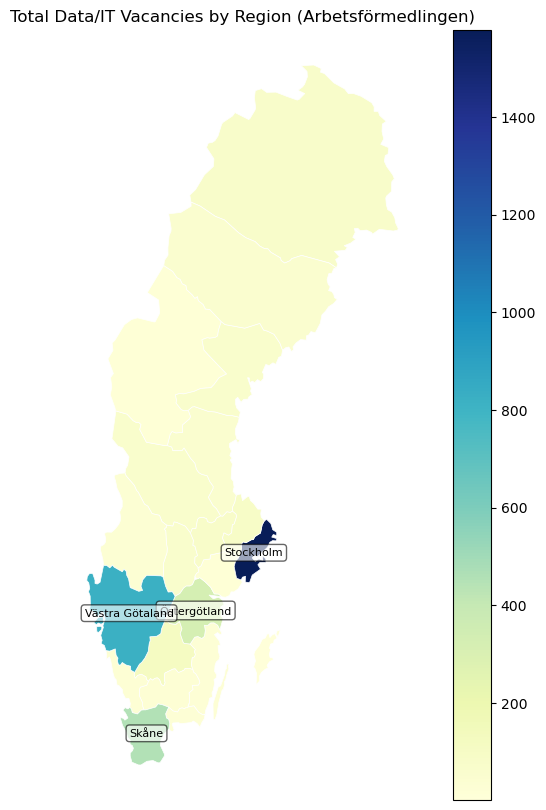

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter for Data/IT jobs:
df_data_it = job_listings_df[
    job_listings_df["occupation_field"]
    .apply(lambda x: x.get("label") if pd.notnull(x) else None) == "Data/IT"
].copy()

# Function to clean region names
def clean_region_name(region_string):
    """
    - Remove the literal ' län' at the end (if present).
    - Remove any trailing 's' from the resulting string.
    """
    if not isinstance(region_string, str):
        return None
    
    # 1. Remove " län"
    region_string = region_string.replace(" län", "")
    
    # 2. Remove trailing 's' if present
    if region_string.endswith("s"):
        region_string = region_string[:-1]
    
    return region_string

# Clean the region names in the Data/IT subset
df_data_it["cleaned_region"] = df_data_it["workplace_address"].apply(
    lambda addr: clean_region_name(addr["region"]) 
                 if isinstance(addr, dict) and "region" in addr else None
)

# Aggregate total Data/IT vacancies by cleaned_region
df_data_it_by_region = (
    df_data_it
    .groupby("cleaned_region")["number_of_vacancies"]
    .sum()
    .reset_index()
    .rename(columns={"cleaned_region": "Region", "number_of_vacancies": "DataIT_Vacancies"})
)

# Load swedish_regions.geojson
regions_geo = gpd.read_file("swedish_regions.geojson")

# Merge the aggregated data with the GeoDataFrame
regions_merged = regions_geo.merge(
    df_data_it_by_region,
    left_on="name",    
    right_on="Region", 
    how="left"
)

# Set a threshold for labeling
label_threshold = 200 

# Plot the choropleth: total Data/IT vacancies by region
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
regions_merged.plot(
    column="DataIT_Vacancies",
    ax=ax,
    legend=True,
    cmap="YlGnBu",
    edgecolor="white",
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)

# Add labels for regions exceeding the threshold
for idx, row in regions_merged.iterrows():
    if row["DataIT_Vacancies"] > label_threshold:
        centroid = row.geometry.centroid
        ax.text(
            centroid.x,
            centroid.y,
            row["Region"],
            fontsize=8,
            ha="center",
            va="center",
            color="black",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6)
        )

plt.title("Total Data/IT Vacancies by Region (Arbetsförmedlingen)")
plt.axis("off")
plt.show()

### Interpretation: Data/IT Vacancies by Region

Data/IT jobs are concentrated in urban areas, with **Stockholm** leading as the top tech hub with over 1,400 vacancies. **Västra Götaland** and **Skåne** also stand out as key centers. Most other regions have minimal opportunities, demonstrating the sector's urban focus and dependence on proximity to tech companies, universities, and skilled labor, which naturally aligns with expectations.

---

## 5. Observations & Discussion

### Potential Extensions

- Analyze other occupation fields to identify other patterns or causes behind their distribution.  
- Incorporate alternative data sources like **LinkedIn** or **Indeed**, especially for tech-related jobs. LinkedIn, for example, shows significantly more computer science roles compared to **Arbetsförmedlingen**.

---

## 6. Conclusion

By merging **Arbetsförmedlingen’s** open job listings with **population** and **municipality boundary** data, we gained an understanding of job opportunities across Sweden.

- **Highly Populated Areas**: While municipalities in and around Stockholm dominate in total job vacancies, they do not exhibit much higher jobs per capita maybe due to large populations which breaks expectations.
- **Healthcare's Influence**: Healthcare drives a significant portion of job vacancies, particularly in southern Sweden and specific rural municipalities. Its demand shapes job density and affects overall job availability analysis.  
- **Tourism-Driven Jobs**: Some municipalities with tourism-oriented economies show higher service job densities, particularly in sectors like hospitality and retail.  
- **Data/IT Jobs**: Data/IT vacancies are concentrated in major economic hubs like Stockholm, Västra Götaland , and Skåne, aligning with expectations.


---
